# Importing Libraries

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

# Preparing the Data

In [2]:
df = pd.read_csv('dataset/train.csv')

In [7]:
# Analysis of Dataframe

df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [8]:
df['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

<AxesSubplot:>

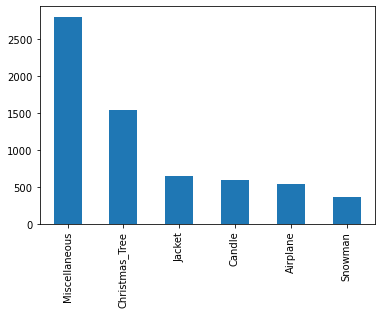

In [9]:
df['Class'].value_counts(sort=True).plot.bar()

In [10]:
# Getting the Images Folder Path

train_image = 'dataset/train'
test_image = 'dataset/test'

In [25]:
# Train and Test split

train_df,valid_df = train_test_split(df, test_size = 0.15, stratify = df.Class.values, shuffle = True)


train_df.reset_index(inplace = True, drop = True)
valid_df.reset_index(inplace = True, drop = True)

In [26]:
# Training Data

train_df.head()

,Image,Class
0,image4833.jpg,Miscellaneous
1,image8663.jpg,Airplane
2,image9781.jpg,Miscellaneous
3,image8026.jpg,Miscellaneous
4,image5703.jpg,Miscellaneous


In [27]:
train_df['Class'].value_counts()

Miscellaneous     2380
Christmas_Tree    1308
Jacket             544
Candle             504
Airplane           455
Snowman            307
Name: Class, dtype: int64

<AxesSubplot:>

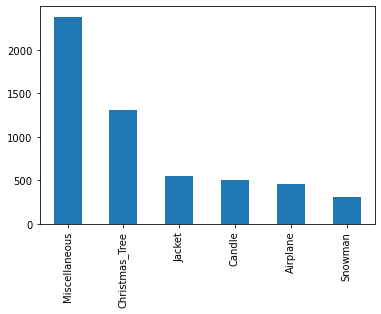

In [28]:
train_df['Class'].value_counts(sort=True).plot.bar()

In [29]:
# Validation Data

valid_df.head()

,Image,Class
0,image7463.jpg,Miscellaneous
1,image4838.jpg,Snowman
2,image6216.jpg,Miscellaneous
3,image3391.jpg,Candle
4,image3589.jpg,Snowman


In [30]:
valid_df['Class'].value_counts()

Miscellaneous     421
Christmas_Tree    231
Jacket             96
Candle             89
Airplane           80
Snowman            54
Name: Class, dtype: int64

<AxesSubplot:>

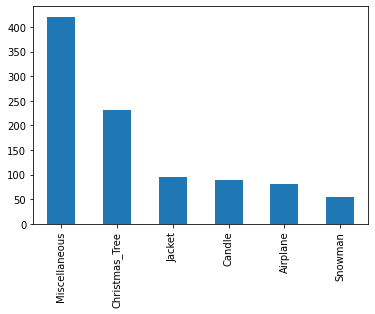

In [31]:
valid_df['Class'].value_counts(sort=True).plot.bar()

# Image Processing

In [32]:
image_size = [299, 299]

In [33]:
# For training

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_dataframe(dataframe=train_df, directory=train_image,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(299, 299), batch_size=32)

Found 5498 validated image filenames belonging to 6 classes.


In [34]:
# For validation

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_dataframe(dataframe=valid_df, directory=train_image,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(299, 299), batch_size=32)

Found 971 validated image filenames belonging to 6 classes.


# Preparing the Model

In [35]:
incep = InceptionResNetV2(input_shape = image_size + [3], weights='imagenet', include_top = False)

# don't train existing weights
for layer in incep.layers:
  layer.trainable = False  

x = Flatten()(incep.output)


prediction = Dense(6, activation='softmax')(x)

# create a model object
model = Model(inputs=incep.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
block17_19 (Lambda)             (None, 17, 17, 1088) 0           block17_18_ac[0][0]              
                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, 17, 17, 1088) 0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_356 (Conv2D)             (None, 17, 17, 128)  139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_356 (BatchN (None, 17, 17, 128)  384         conv2d_356[0][0]                 
__________________________________________________________________________________________________
activation

# Build/Compile the Model

In [36]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [38]:
# Fitting

holiday = model.fit_generator(
  training_set,
  validation_data = validation_set,
  epochs = 12,
  steps_per_epoch = training_set.n//32,
  validation_steps = validation_set.n//32 
)

Epoch 1/12
171/171 [==============================] - 1613s 9s/step - loss: 3.3112 - accuracy: 0.7887 - val_loss: 2.3372 - val_accuracy: 0.8604
Epoch 2/12
171/171 [==============================] - 1517s 9s/step - loss: 2.0006 - accuracy: 0.8644 - val_loss: 2.3226 - val_accuracy: 0.8750
Epoch 3/12
171/171 [==============================] - 1389s 8s/step - loss: 1.6736 - accuracy: 0.8935 - val_loss: 2.4899 - val_accuracy: 0.8729
Epoch 4/12
171/171 [==============================] - 18487s 108s/step - loss: 1.3339 - accuracy: 0.9177 - val_loss: 2.0957 - val_accuracy: 0.8813
Epoch 5/12
171/171 [==============================] - 1423s 8s/step - loss: 1.3149 - accuracy: 0.9184 - val_loss: 2.0505 - val_accuracy: 0.8844
Epoch 6/12
171/171 [==============================] - 1385s 8s/step - loss: 1.2565 - accuracy: 0.9316 - val_loss: 2.4763 - val_accuracy: 0.9083
Epoch 7/12
171/171 [==============================] - 1339s 8s/step - loss: 0.9488 - accuracy: 0.9440 - val_loss: 3.4787 - val_accura

# Plot Loss/Accuracy

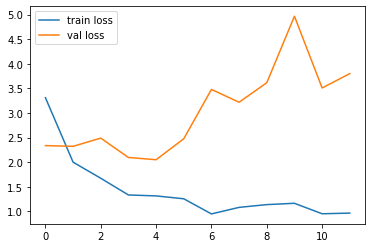

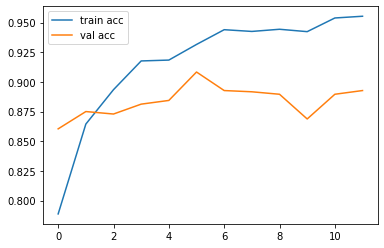

<Figure size 432x288 with 0 Axes>

In [39]:
# Loss
plt.plot(holiday.history['loss'], label='train loss')
plt.plot(holiday.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracies
plt.plot(holiday.history['accuracy'], label='train acc')
plt.plot(holiday.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Predictions for Test Data

In [44]:
name = []
y_pred = []
labels = (training_set.class_indices)
labels = dict((v, k) for k, v in labels.items())
for i in os.listdir('dataset/test'):
    name.append(i)
    i = 'dataset/test/' + i
    img = image.load_img(i, target_size = (299,299,3))
    img = image.img_to_array(img) / 255
    pred = model.predict(img.reshape(1,299,299,3))
    y_pred.append(labels[np.argmax(pred[0])])
    
data = pd.DataFrame((zip(name, y_pred)), columns = ['Image', 'Class'])
data.head()

,Image,Class
0,image8799.jpg,Jacket
1,image1965.jpg,Miscellaneous
2,image4821.jpg,Airplane
3,image1795.jpg,Miscellaneous
4,image444.jpg,Miscellaneous


In [45]:
data.shape

(3489, 2)

In [46]:
# Save submission data

data.to_csv('he_holiday_submission1.csv', index = False)